In [5]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0, '/Users/eman/Documents/' +
                'code_projects/kernellib/kernellib/regression/')

sys.path.insert(0, '/home/emmanuel/github_repos/kernellib/kernellib/')

In [7]:
from regression.krr import KRR

### Experiment with Sample Size

In [8]:
sample_sizes = 10000 * np.arange(1, 10)
random_state = 123

batch_times = []
naive_times = []


for iteration, n_samples in enumerate(sample_sizes):
    
    print('Iteration: {}'.format(100*iteration/len(sample_sizes)))
    
    # create data
    x_data, y_data = make_regression(n_samples=n_samples, 
                                     n_features=n_features,
                                     random_state=random_state)
    
    # split data into training and testing
    train_percent = 0.2

    x_train, x_test, y_train, y_test = train_test_split(
        x_data, y_data, train_size=train_percent,
        random_state=random_state
    )
    
    # remove the mean from the training data
    y_mean = np.mean(y_train)

    y_train -= y_mean
    y_test -= y_mean


    # initialize the kernel ridge regression model
    krr_model = KRR(n_batches=1)

    # fit model to data
    krr_model.fit(x_train, y_train)

    
    # PREDICTING TIMES
    # predict using the krr model
    start = time()
    y_pred = krr_model.predict(x_test)
    naive_times.append(time() - start)
    
    # initialize the kernel ridge regression model
    krr_model = KRR(n_batches=10)

    # fit model to data
    krr_model.fit(x_train, y_train)

    
    # PREDICTING TIMES
    # predict using the krr model
    start = time()
    y_pred = krr_model.predict(x_test)
    batch_times.append(time() - start)
    
    

Iteration: 0.0


NameError: name 'n_features' is not defined

In [12]:



print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(2000, 100) (2000,)
(8000, 100) (8000,)


In [13]:
# initialize the kernel ridge regression model
krr_model = KRR(n_batches=1)

# fit model to data
krr_model.fit(x_train, y_train)

# predict using the krr model
y_pred = krr_model.predict(x_test)

In [29]:
import numpy as np
import warnings 
from sklearn.model_selection import train_test_split
import scipy as scio
from scipy.spatial.distance import pdist
from scipy.linalg import cho_factor, cho_solve, cholesky
from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import mean_squared_error
from sklearn.utils import check_array, check_random_state
from sklearn.linear_model.ridge import _solve_cholesky_kernel as kernel_solve
from time import time

%matplotlib inline
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [31]:
# parameter heuristics
mean_sigma = np.mean(pdist(x_train, metric='euclidean'))
lam = 1e-04

mean_gamma = 1 / (2 * mean_sigma ** 2)

# construct kernel matrices
K_train = rbf_kernel(X=x_train, gamma=mean_gamma)

### Different Solvers

In [32]:
weights = {}
times = {}

In [33]:
# slow method: solve problem
t0 = time()
weights['solver'] = \
    scio.linalg.solve(K_train + lam * np.eye(x_train.shape[0]), 
                      y_train)
t1 = time() - t0
print('Time taken for solve: {:.4f} secs'.format(t1))

Time taken for solve: 1.1514 secs


In [34]:
# scikit kernel cholesky solver
t0 = time()
weights['scikit_solver'] = kernel_solve(K_train, y_train, lam)
t1 = time() - t0
print('Time taken for scikit-solver: {:.4f} secs'.format(t1))

Time taken for scikit-solver: 0.9169 secs


In [35]:
# cholesky: decomposition: manually
t0 = time()
R = cholesky(K_train + lam * np.eye(x_train.shape[0]))
weights['chol_solver'] = scio.linalg.solve(R, scio.linalg.solve(R.T, y_train))
t1 = time() - t0
print('Time taken for cholesky manually: {:.4f} secs'.format(t1))

Time taken for cholesky manually: 2.2474 secs


In [36]:
# cholesky decomposition: with functions
t0 = time()
R, lower = cho_factor(K_train + lam * np.eye(x_train.shape[0]))
weights['chol_factor'] = cho_solve((R, lower), y_train)
t1 = time() - t0
print('\nTime taken for cholesky with functions: {:.4f} secs\n'.format(t1))


Time taken for cholesky with functions: 0.5631 secs



#### Are they the same?

In [37]:
print('Scikit Solver: {}'.format(
    np.allclose(weights['scikit_solver'],
                weights['solver'])))

print('Cholesky Solver: {}'.format(
    np.allclose(weights['chol_solver'],
                weights['solver'])))

print('Cholesky Factor: {}'.format(
    np.allclose(weights['chol_factor'],
                weights['solver'])))

Scikit Solver: True
Cholesky Solver: True
Cholesky Factor: True


#### Are they faster?

In [38]:
solver_time = %timeit -o scio.linalg.solve(K_train + lam * np.eye(x_train.shape[0]), y_train)
scikit_time = %timeit -o kernel_solve(K_train, y_train, lam)

1.19 s ± 104 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
783 ms ± 33.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%%timeit

# Cholesky Manual Solve
R = cholesky(K_train + lam * np.eye(x_train.shape[0]))
weights['chol_solver'] = scio.linalg.solve(R, scio.linalg.solve(R.T, y_train))
t1 = time() - t0

2.46 s ± 124 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
%%timeit

# Cholesky Factor Solve
R, lower = cho_factor(K_train + lam * np.eye(x_train.shape[0]))
weights['chol_factor'] = cho_solve((R, lower), y_train)

555 ms ± 10 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Predictions (Normal)


In [41]:
%%timeit

# calculate the kernel test matrix
K_test = rbf_kernel(X=x_test, gamma=mean_gamma)

# calculate the inverse matrix
K_train_inv = np.linalg.inv(K_train)

# calculate the train-test Kernel matrix
K_traintest = rbf_kernel(x_train, x_test, gamma=mean_gamma)

# calculate the predictions
y_pred = K_traintest.T @ weights['solver']

# calculate the variance
y_var = np.diag(K_test) - np.diag(K_traintest.T @ K_train_inv @ K_traintest)

11.4 s ± 1.08 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Predictions (Batch)

In [42]:
# split testing data (K-fold)
n_samples, n_dimensions = x_test.shape
n_samples_per_batch = 100
n_batches = int(np.round(n_samples / n_samples_per_batch))

print("Number of Test samples: ", n_samples)
print("Number of samples per batch: ", n_samples_per_batch)
print("Number of batches: {}".format(n_batches))

Number of Test samples:  6000
Number of samples per batch:  100
Number of batches: 60


In [43]:
%%timeit

# Create Batch Iterator Object
BatchIterator = KFold(n_splits=n_batches)

# predefine matrices
y_pred = np.empty(y_test.shape)
variance = np.empty(y_test.shape) 

# calculate the inverse matrix
K_train_inv = np.linalg.inv(K_train)

for (ibatch, (_, ibatch_index)) in enumerate(BatchIterator.split(x_test)):
    
    # calculate the train-test kernel
    K_traintest = rbf_kernel(x_train, x_test[ibatch_index], 
                             gamma=mean_gamma)
    
    # calculate the predictions
    y_pred[ibatch_index] = K_traintest.T @ weights['solver']
    
    # calculate the variance
    K_batch = rbf_kernel(x_test[ibatch_index], gamma=mean_gamma)
    
    variance[ibatch_index, 0] = np.diag(K_batch) - \
        np.diag(K_traintest.T @ K_train_inv @ K_traintest)

6.9 s ± 349 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
BatchIterator = KFold(n_splits=n_batches)

# predefine matrices
y_pred = np.empty(y_test.shape)
variance = np.empty(y_test.shape) 

# calculate the inverse matrix
K_train_inv = np.linalg.inv(K_train)

for (ibatch, (_, ibatch_index)) in enumerate(BatchIterator.split(x_test)):
    
    # calculate the train-test kernel
    K_traintest = rbf_kernel(x_train, x_test[ibatch_index], 
                             gamma=mean_gamma)
    
    # calculate the predictions
    y_pred[ibatch_index] = K_traintest.T @ weights['solver']
    
    # calculate the variance
    K_batch = rbf_kernel(x_test[ibatch_index], gamma=mean_gamma)
    
    variance[ibatch_index, 0] = np.diag(K_batch) - \
        np.diag(K_traintest.T @ K_train_inv @ K_traintest)

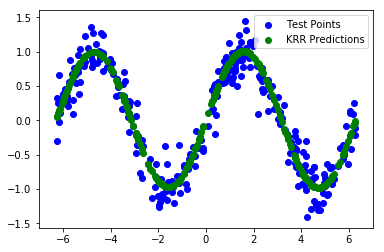

In [45]:
fig, ax = plt.subplots()

ax.scatter(x_test[::20], y_test[::20], color='b', label='Test Points')
ax.scatter(x_test[::20], y_pred[::20], color='g', label='KRR Predictions')


ax.legend()
plt.show()